In [34]:
import pandas as pd
import numpy as np
import copy
import re
import random
import os
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split as tts
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier, CatBoostRegressor

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42) # Seed 고정

train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
submission = pd.read_csv('sample_submission.csv')

In [35]:
#핫덱대체
#근로기간 Unknown <<< 나머지 학습해서 결과 뽑기?
"""
    근로기간
    10+ years    31585
    2 years       8450
    < 1 year      7774
    3 years       7581
    1 year        6249
    Unknown       5671 << 5.8% 정도
    5 years       5665
    4 years       5588
    8 years       4888
    6 years       3874
    7 years       3814
    9 years       3744
    10+years       896
    <1 year        370
    3               89
    1 years         56
"""

'\n    근로기간\n    10+ years    31585\n    2 years       8450\n    < 1 year      7774\n    3 years       7581\n    1 year        6249\n    Unknown       5671 << 5.8% 정도\n    5 years       5665\n    4 years       5588\n    8 years       4888\n    6 years       3874\n    7 years       3814\n    9 years       3744\n    10+years       896\n    <1 year        370\n    3               89\n    1 years         56\n'

In [36]:
def only_int(string):
    num = re.sub(r'[^0-9]', '', string)
    if num:
        return num
    else:
        return "5"

def extract_categorical_columns(df):
    data = []
    for e, i in enumerate(df.columns):
        if df[i].dtypes == 'object':
            data.append(i)
    return data

def ordinal_encoding(train_df, test_df, categorical_columns):
    from sklearn.preprocessing import OrdinalEncoder
    train, test = train_df.copy(), test_df.copy()
    data = {}
    for col in categorical_columns:
        ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
        ordinal_encoder.fit(train[col].values.reshape(-1, 1))
        train[col] = ordinal_encoder.transform(train[col].values.reshape(-1, 1)).reshape(-1)
        if col in test:
            test[col] = ordinal_encoder.transform(test[col].values.reshape(-1, 1)).reshape(-1)
        data[col] = ordinal_encoder
    return train, test, data

def sep_ml_xy(df, target):
    y = df[target]
    x = df.drop(columns=target)
    return x, y

def ml_train_valid(model, metric, metric_options, train_data, train_target, test_data, test_target):
    model = model.fit(train_data, train_target)
    pred = model.predict(test_data)
    evaluate = metric(test_target, pred, **metric_options)
    return pred, evaluate, model

def ml_predict(model, test_data):
    pred = model.predict(test_data)
    return pred

In [37]:
train = train.drop(columns=['ID'])
test = test.drop(columns=['ID'])

for span in ["근로기간"]:
    train[span] = train[span].apply(lambda x: int(only_int(x)))
    test[span] = test[span].apply(lambda x: int(only_int(x)))

for span in ["대출기간"]:
    train[span] = train[span].apply(lambda x: int(int(only_int(x))/12))
    test[span] = test[span].apply(lambda x: int(int(only_int(x))/12))
    
for span in ["총상환이자", "총연체금액", "연체계좌수"]:
    train[span] = train[span].apply(lambda x: int(x))
    test[span] = test[span].apply(lambda x: int(x))
# display(train.head(3), test.head(3))

In [38]:
categorical_features = ['주택소유상태', '대출목적']

for i in categorical_features:
    le = LabelEncoder()
    le=le.fit(train[i]) 
    train[i]=le.transform(train[i])
    
    for case in np.unique(test[i]):
        if case not in le.classes_: 
            le.classes_ = np.append(le.classes_, case) 
    test[i]=le.transform(test[i])

# display(train.head(3), test.head(3))

In [39]:
# columns_to_scale = ['대출금액','연간소득', '부채_대비_소득_비율', '총상환원금', '총상환이자', '총연체금액']
# 대출금액, 대출기간, 근로기간, 주택소유상태, 연간소득, 부채_대비_소득_비율, 총계좌수, 대출목적, 최근_2년간_연체_횟수, 총상환원금, 총상환이자, 총연체금액, 연쳬계좌수

# 의미 있는 값 : 근로기간, 주택소유상태, 연간소득, 부채_대비_소득_비율, 대출목적, 최근_2년간_연체_횟수, 총상환원금, 총상환이자, 총연체금액
# 의미 없는 값 : 대출금액, 대출기간, 총계좌수, 연체계좌수, 
# 추가 하는 값 : 연체계좌수/총계좌수, 총상환원금+총상환이자-총연체금액/대출원금, 대출금액/대출기간/연간소득, 

# scaler = MinMaxScaler(feature_range=(0, 10))
# train[columns_to_scale] = scaler.fit_transform(train[columns_to_scale])
# test[columns_to_scale] = scaler.transform(test[columns_to_scale])

# Calculate additional values
train['연체계좌수/총계좌수'] = train['연체계좌수'] / train['총계좌수']
train['총상환원금+총상환이자-총연체금액/대출원금'] = (train['총상환원금'] + train['총상환이자'] - train['총연체금액']) / train['대출금액']

test['연체계좌수/총계좌수'] = test['연체계좌수'] / test['총계좌수']
test['총상환원금+총상환이자-총연체금액/대출원금'] = (test['총상환원금'] + test['총상환이자'] - test['총연체금액']) / test['대출금액']

columns_to_scale = ['연체계좌수/총계좌수', '총상환원금+총상환이자-총연체금액/대출원금']
scaler = MinMaxScaler(feature_range=(0, 10))
train[columns_to_scale] = scaler.fit_transform(train[columns_to_scale])
test[columns_to_scale] = scaler.transform(test[columns_to_scale])

# Remove meaningless values
# '대출금액', '대출기간', '총계좌수', '연체계좌수'

train = train.drop(columns=['최근_2년간_연체_횟수', '총계좌수'])
test = test.drop(columns=['최근_2년간_연체_횟수', '총계좌수'])

display(train.head(3), test.head(3))

,대출금액,대출기간,근로기간,주택소유상태,연간소득,부채_대비_소득_비율,대출목적,총상환원금,총상환이자,총연체금액,연체계좌수,대출등급,연체계좌수/총계좌수,총상환원금+총상환이자-총연체금액/대출원금
0,12480000,3,6,3,72000000,18.90,1,0,0,0,0,C,0.0,0.002985
1,14400000,5,10,1,130800000,22.33,10,373572,234060,0,0,B,0.0,0.406111
2,12000000,3,5,1,96000000,8.60,1,928644,151944,0,0,A,0.0,0.863269


,대출금액,대출기간,근로기간,주택소유상태,연간소득,부채_대비_소득_비율,대출목적,총상환원금,총상환이자,총연체금액,연체계좌수,연체계좌수/총계좌수,총상환원금+총상환이자-총연체금액/대출원금
0,16800000,3,8,1,132000000,19.64,10,394692,146604,0,0,0.0,0.310799
1,8400000,3,5,3,89971200,15.84,1,0,0,0,0,0.0,0.002985
2,17280000,3,6,3,150000000,8.41,3,1786980,281820,0,0,0.0,1.146752


In [40]:
from sklearn.model_selection import GridSearchCV

categorical_columns = extract_categorical_columns(train)
train, test, ord_dict = ordinal_encoding(train, test, categorical_columns)
train_x, train_y = sep_ml_xy(train, "대출등급")
train_x, valid_x, train_y, valid_y = tts(train_x, train_y, train_size=0.8, shuffle=True, random_state=0)

model = CatBoostClassifier()
model = model.fit(train_x, train_y)

Learning rate set to 0.098752
0:	learn: 1.8082826	total: 15.5ms	remaining: 15.5s
1:	learn: 1.7090949	total: 29.8ms	remaining: 14.9s
2:	learn: 1.6280436	total: 43ms	remaining: 14.3s
3:	learn: 1.5522063	total: 57.5ms	remaining: 14.3s
4:	learn: 1.4954395	total: 71.2ms	remaining: 14.2s
5:	learn: 1.4360622	total: 86.5ms	remaining: 14.3s
6:	learn: 1.3875061	total: 101ms	remaining: 14.3s
7:	learn: 1.3458484	total: 116ms	remaining: 14.4s
8:	learn: 1.3070590	total: 130ms	remaining: 14.4s
9:	learn: 1.2746701	total: 144ms	remaining: 14.3s
10:	learn: 1.2410893	total: 159ms	remaining: 14.3s
11:	learn: 1.2220937	total: 172ms	remaining: 14.1s
12:	learn: 1.1933819	total: 186ms	remaining: 14.1s
13:	learn: 1.1682656	total: 201ms	remaining: 14.2s
14:	learn: 1.1513517	total: 213ms	remaining: 14s
15:	learn: 1.1305613	total: 228ms	remaining: 14s
16:	learn: 1.1090314	total: 244ms	remaining: 14.1s
17:	learn: 1.0892459	total: 258ms	remaining: 14.1s
18:	learn: 1.0703776	total: 272ms	remaining: 14.1s
19:	learn: 

In [41]:
from sklearn.model_selection import KFold,StratifiedKFold
from sklearn.metrics import log_loss
def to_categorical(y, num_classes=None, dtype="float32"):
    y = np.array(y, dtype="int")
    input_shape = y.shape

    # Shrink the last dimension if the shape is (..., 1).
    if input_shape and input_shape[-1] == 1 and len(input_shape) > 1:
        input_shape = tuple(input_shape[:-1])

    y = y.reshape(-1)
    if not num_classes:
        num_classes = np.max(y) + 1
    n = y.shape[0]
    categorical = np.zeros((n, num_classes), dtype=dtype)
    categorical[np.arange(n), y] = 1
    output_shape = input_shape + (num_classes,)
    categorical = np.reshape(categorical, output_shape)
    return categorical

cat_models={}

def cat_kfold(max_depth, learning_rate, random_seed):
    
    folds=StratifiedKFold(n_splits=10, shuffle=True, random_state=55)
    outcomes=[]
    sub=np.zeros((test.shape[0], 7))  
    
    for seed in random_seed:
        for n_fold, (train_index, val_index) in enumerate(folds.split(train_x, train_y)):
            print(f'===================================={n_fold+1}============================================')
            
            X_train, X_val = train_x.iloc[train_index], train_x.iloc[val_index]
            y_train, y_val = train_y.iloc[train_index], train_y.iloc[val_index]

            # early_stopping 50에서 가장 좋은 점수를 내는 learning_rate를 활용
            cat = CatBoostClassifier(n_estimators=3000, max_depth=max_depth, random_seed=seed, learning_rate=learning_rate, bootstrap_type ='Bernoulli')
            cat.fit(X_train, y_train,
                  eval_set=[(X_train, y_train), (X_val, y_val)],
                  early_stopping_rounds=50,
                  verbose=100)

            cat_models[n_fold] = cat

            # val 데이터 예측
            predictions = cat.predict_proba(X_val)
            # test 데이터 예측
            test_predictions = cat.predict_proba(test)

            # val 데이터 예측 logloss 값 저장
            logloss=log_loss(to_categorical(y_val), predictions)
            outcomes.append(logloss)
            print(f"FOLD {n_fold+1} : logloss:{logloss}")

            # test 데이터 예측 결과 종합
            # 최종 적으로는 kolds 횟수 만큼 나눠서 평균 값을 활용
            sub+=test_predictions

            print(f'================================================================================\n\n')

    # 저장된 val 데이터 예측 logloss 값의 평균 값으로 성능을 비교
    mean_outcome=np.mean(outcomes)
    print("Mean:{}".format(mean_outcome))
    
    return sub/(folds.n_splits * len(random_seed))

In [42]:
my_submission = cat_kfold(8, 0.04, [1042])

====================================1============================================
0:	learn: 1.8854585	test: 1.8854585	test1: 1.8863855	best: 1.8863855 (0)	total: 28.2ms	remaining: 1m 24s
100:	learn: 0.7665692	test: 0.7665692	test1: 0.7893463	best: 0.7893463 (100)	total: 2.62s	remaining: 1m 15s
200:	learn: 0.6268084	test: 0.6268084	test1: 0.6516550	best: 0.6516550 (200)	total: 5.22s	remaining: 1m 12s
300:	learn: 0.5662885	test: 0.5662885	test1: 0.5925835	best: 0.5925835 (300)	total: 7.81s	remaining: 1m 10s
400:	learn: 0.5209284	test: 0.5209284	test1: 0.5485357	best: 0.5485357 (400)	total: 10.4s	remaining: 1m 7s
500:	learn: 0.4912140	test: 0.4912140	test1: 0.5217211	best: 0.5217211 (500)	total: 13s	remaining: 1m 4s
600:	learn: 0.4688978	test: 0.4688978	test1: 0.5037596	best: 0.5037596 (600)	total: 15.5s	remaining: 1m 2s
700:	learn: 0.4501619	test: 0.4501619	test1: 0.4888305	best: 0.4888305 (700)	total: 18.1s	remaining: 59.4s
800:	learn: 0.4348904	test: 0.4348904	test1: 0.4776195	best: 0.

In [ ]:
import matplotlib.font_manager

findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
/usr/lib/python3/dist-packages/IPython/core/events.py:88: UserWarning: Glyph 52509 (\N{HANGUL SYLLABLE CONG}) missing from current font.
  func(*args, **kwargs)
/usr/lib/python3/dist-packages/IPython/core/events.py:88: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from current font.
  func(*args, **kwargs)
/usr/lib/python3/dist-packages/IPython/core/events.py:88: UserWarning: Glyph 54872 (\N{HANGUL SYLLABLE HWAN}) missing from current font.
  func(*args, **kwargs)
/usr/lib/python3/dist-packages/IPython/core/events.py:88: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from current font.
  func(*args, **kwargs)
/usr/lib/python3/dist-packages/IPython/core/events.py:88: UserWarning: Glyph 51088 (\N{HANGUL SYLLABLE JA}) missing from current font.
  func(*args, **kwargs)
findfont: Font family 'NanumGothic' not found.
/usr/lib/python3/dist-packages/IPython/core/events.py:88: U

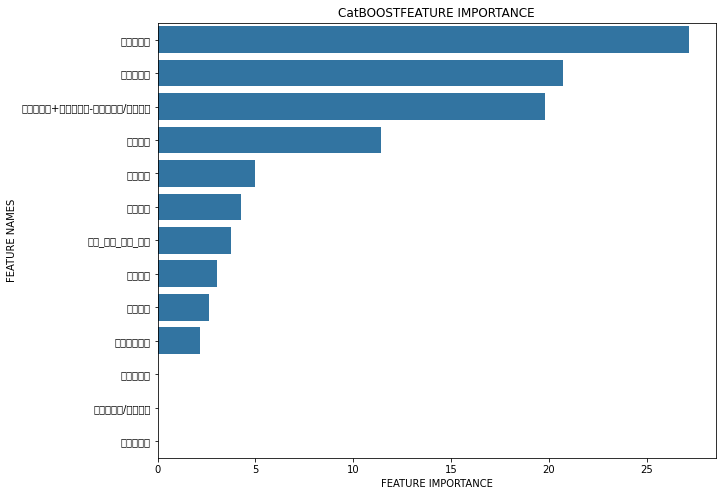

In [59]:
plt.rc('font', family='NanumGothic')
def plot_feature_importance(importance, names, model_type):
    
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    
    plt.figure(figsize=(10,8))
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

plot_feature_importance(cat_models[0].get_feature_importance(), train_x.columns,'CatBOOST')

In [44]:

model = CatBoostClassifier(n_estimators=1000, learning_rate=0.1, max_depth=10, verbose=100, task_type='GPU')
model = model.fit(train_x, train_y, early_stopping_rounds=200, eval_set=[(valid_x, valid_y)])
pred = model.predict(valid_x)
evaluate = f1_score(valid_y, pred, average="macro")

#_, evaluate, model = ml_train_valid(model, f1_score, {"average": "macro"}, train_x, train_y, valid_x, valid_y)

0:	learn: 1.7482289	test: 1.7493181	best: 1.7493181 (0)	total: 27.6ms	remaining: 27.5s
100:	learn: 0.5379945	test: 0.5577457	best: 0.5577457 (100)	total: 2.2s	remaining: 19.6s
200:	learn: 0.4549936	test: 0.5011789	best: 0.5011789 (200)	total: 4.43s	remaining: 17.6s
300:	learn: 0.4063946	test: 0.4800106	best: 0.4800106 (300)	total: 6.77s	remaining: 15.7s
400:	learn: 0.3688042	test: 0.4703014	best: 0.4702902 (398)	total: 9.2s	remaining: 13.7s
500:	learn: 0.3378826	test: 0.4653447	best: 0.4653265 (499)	total: 11.7s	remaining: 11.6s
600:	learn: 0.3104226	test: 0.4608689	best: 0.4608451 (599)	total: 14.1s	remaining: 9.36s
700:	learn: 0.2867822	test: 0.4592758	best: 0.4592758 (700)	total: 16.6s	remaining: 7.07s
800:	learn: 0.2668497	test: 0.4579063	best: 0.4578647 (799)	total: 19s	remaining: 4.73s
900:	learn: 0.2487191	test: 0.4571583	best: 0.4569852 (886)	total: 21.5s	remaining: 2.37s
999:	learn: 0.2316250	test: 0.4574367	best: 0.4569852 (886)	total: 24.1s	remaining: 0us
bestTest = 0.456985

In [45]:
from datetime import datetime

print("valid score:", evaluate)
pred = ml_predict(model, test)
submission['대출등급'] = ord_dict["대출등급"].inverse_transform(pred.reshape(-1, 1)).reshape(-1)

print(submission)

current_datetime = datetime.now().strftime("%y%m%d.%H%M")
print(current_datetime)

submission.to_csv('cat'+current_datetime+'.csv', index=False)

valid score: 0.7283772222187792
               ID 대출등급
0      TEST_00000    B
1      TEST_00001    C
2      TEST_00002    A
3      TEST_00003    C
4      TEST_00004    C
...           ...  ...
64192  TEST_64192    D
64193  TEST_64193    D
64194  TEST_64194    D
64195  TEST_64195    C
64196  TEST_64196    A

[64197 rows x 2 columns]
240124.2313
